# Research paper Regarding the Food101 experiment:
https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment

##What does mixed precision training do?

##Mixed precision training uses a combination of single precision (float32) and
## half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-eac7d30a-c69c-aba3-e5e8-3795911f391e)


In [2]:
import tensorflow as tf
tf.__version__

'2.19.0'

In [3]:
# Add timestamp
import datetime
print(f"Notebook last run (end-to-end):{datetime.datetime.now()}")

Notebook last run (end-to-end):2025-09-10 14:13:09.253681


In [4]:
# get helperfunctions file
import os

if not os.path.exists('helper_functions.py'):
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
  print("[INFO] 'helper_functions.py' already exists, skipping download")

--2025-09-10 14:13:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-09-10 14:13:09 (7.36 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [6]:
# get tensorflow datasets
import tensorflow_datasets as tfds

In [7]:
# get all available datasets in tfds
datasets_list = tfds.list_builders()
print(datasets_list)

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'ai2dcaption', 'aloha_mobile', 'amazon_us_reviews', 'anli', 'answer_equivalence', 'arc', 'asimov_dilemmas_auto_val', 'asimov_dilemmas_scifi_train', 'asimov_dilemmas_scifi_val', 'asimov_injury_val', 'asimov_multimodal_auto_val', 'asimov_multimodal_manual_val', 'asqa', 'asset', 'assin2', 'asu_table_top_converted_externally_to_rlds', 'austin_buds_dataset_converted_externally_to_rlds', 'austin_sailor_dataset_converted_externally_to_rlds', 'austin_sirius_dataset_converted_externally_to_rlds', 'bair_robot_pushing_small', 'bc_z', 'bccd', 'beans', 'bee_dataset', 'beir', 'berkeley_autolab_ur5', 'berkeley_cable_routing', 'berkeley_fanuc_manipulation', 'berkeley_gnm_cory_hall', 'berkeley_gnm_recon', 'berkeley_gnm_sac_son', 'berkeley_mvp_converted_externally_to_rlds', 'berkeley_rpt_converted_externally_to_rlds', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'b

In [8]:
target_dataset = 'food101'
print(f'{target_dataset} in tensorflow Datasets:{target_dataset in datasets_list}')

food101 in tensorflow Datasets:True


In [9]:
# load the data
(train_data, test_data), ds_info = tfds.load(name = target_dataset,
                                             split = ['train','validation'],
                                             shuffle_files = True,
                                             as_supervised = True,
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.TBNI44_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.TBNI44_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [10]:
# features of Food101 tfds
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [11]:
# get class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [12]:
# take one sample of the training datal
train_one_sample = train_data.take(1) #samples are in format(image_tensor, label)

In [13]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
# output info of train data
for  image, label in train_one_sample:
  print(f"""
  IMAGE SHAPE: {image.shape}
  IMAGE DTYPE: {image.dtype}
  Target class from Food 101 (tensor form):{label}
  Class names: {class_names[label.numpy()]}
        """)


  IMAGE SHAPE: (384, 512, 3)
  IMAGE DTYPE: <dtype: 'uint8'>
  Target class from Food 101 (tensor form):97
  Class names: takoyaki
        


In [15]:
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[ 54,  30,  26],
        [ 57,  33,  29],
        [ 72,  49,  43],
        ...,
        [192, 184, 163],
        [190, 179, 159],
        [181, 169, 147]],

       [[ 51,  28,  22],
        [ 60,  37,  31],
        [ 81,  58,  52],
        ...,
        [191, 183, 162],
        [189, 176, 157],
        [176, 164, 142]],

       [[ 78,  58,  49],
        [ 96,  76,  67],
        [122, 102,  93],
        ...,
        [191, 183, 162],
        [188, 175, 156],
        [172, 157, 136]],

       ...,

       [[162, 140, 117],
        [164, 142, 119],
        [169, 147, 126],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[168, 146, 123],
        [170, 148, 125],
        [176, 154, 131],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[173, 151, 128],
        [176, 154, 131],
        [182, 160, 137],
        ...,
        [  4,   4,   

In [16]:
# what are the min and max values
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from dataset

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

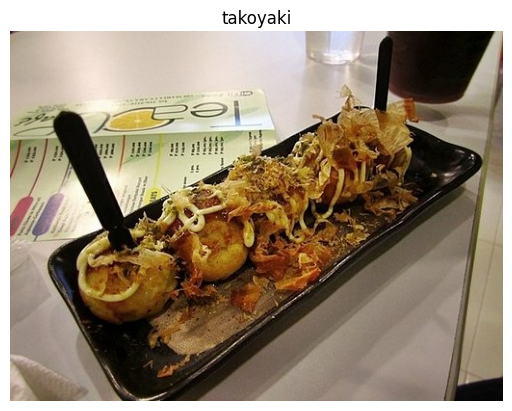

In [17]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [18]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape = 224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes the images to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label #return (float32_image, label)

In [19]:
# preprocess a single image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f'Image before preprocessing:\n{image[:2]}, \nShape:{image.shape},\ndtype:{image.dtype}\n')
print(f'Image after preprocesing:\n{preprocessed_img[:2]},\nShape:{preprocessed_img.shape},\ndtype:{preprocessed_img.dtype}')

Image before preprocessing:
[[[ 54  30  26]
  [ 57  33  29]
  [ 72  49  43]
  ...
  [192 184 163]
  [190 179 159]
  [181 169 147]]

 [[ 51  28  22]
  [ 60  37  31]
  [ 81  58  52]
  ...
  [191 183 162]
  [189 176 157]
  [176 164 142]]], 
Shape:(384, 512, 3),
dtype:<dtype: 'uint8'>

Image after preprocesing:
[[[ 56.23469   32.591835  27.877552]
  [ 98.16328   75.16328   68.50001 ]
  [121.62245  101.62245   91.63265 ]
  ...
  [191.72456  191.36736  170.93883 ]
  [202.18863  196.9743   176.90286 ]
  [185.918    174.10167  153.6169  ]]

 [[ 93.47959   73.55102   64.19388 ]
  [144.57143  124.64286  113.561226]
  [169.66327  150.20409  138.79082 ]
  ...
  [196.22955  195.22955  176.80103 ]
  [202.02025  194.9335   175.87225 ]
  [182.24942  168.44324  148.72888 ]]],
Shape:(224, 224, 3),
dtype:<dtype: 'float32'>


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

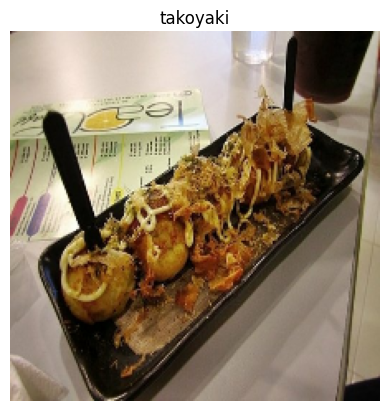

In [20]:
# we can still plot the image if we normalize the image between - 0 and 1
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False)

#Batch and prepare Dataset

In [21]:
# Map preprocesing function to training data
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)
# shuffle train data and turn it into batches
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# preprocessing function to test dataset
# Map preprocesing function to training data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)
# shuffle train data and turn it into batches
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)


In [22]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Creating modelling callbacks

In [23]:
from helper_functions import create_tensorboard_callback

# create modelcheckpoint to save model training progress
checkpoint_path = 'model_checkpoint/cp.weights.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = 'val_accuracy',
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 0)

# Setup precision training

In [24]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy = 'mixed_float16') #set global policy to mixed precision

In [25]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

#Build Feature extraction model

In [26]:
from tensorflow.keras import layers
# create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# create functional model
inputs = layers.Input(shape = input_shape, name = 'input_layer')
# x  =layers.Rescaling(1./255)(x) # for models such as ResNet50
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name = 'pooling_layer')(x)
x = layers.Dense(len(class_names))(x)
# Separate activation layer in order to hardcode dtype to float32
outputs = layers.Activation('softmax', dtype = tf.float32, name  = 'softmax_activation_layer')(x)
model = tf.keras.Model(inputs, outputs)
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_activation_layer        │ (None, 101)            │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# Checking layer dtype policies(are we using mixed precision?)

🔑 Note: A layer can have a dtype of float32 and a dtype policy of "mixed_float16" because it stores its variables (weights & biases) in float32 (more numerically stable), however it computes in float16 (faster).

In [28]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) #dtype_policy is the data type  a layer computes in

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_activation_layer True float32 <DTypePolicy "float32">


In [29]:
# checking  the same for our layers base model
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer False float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16"

🔑 Note: The mixed precision API automatically causes layers which can benefit from using the "mixed_float16" dtype policy to use it. It also prevents layers which shouldn't use it from using it (e.g. the normalization layer at the start of the base model)

# fit the feature extraction model

In [30]:
# Turn off all warnings except for errors.
# tf.get_logger().setLevel('ERROR')

# FIT the model with callbacks
history_feature_extractor = model.fit(train_data,
                                      epochs = 5,
                                      steps_per_epoch = len(train_data),
                                      validation_data = test_data,
                                      validation_steps = int(0.15*len(test_data)),
                                      callbacks = [create_tensorboard_callback('training_logs',
                                                                               'efficentnetB0_feature_extractor'),
                                                   model_checkpoint])

Saving TensorBoard log files to: training_logs/efficentnetB0_feature_extractor/20250910-142606
Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 260s 86ms/step - accuracy: 0.4782 - loss: 2.2758 - val_accuracy: 0.6984 - val_loss: 1.1410
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 168s 65ms/step - accuracy: 0.6695 - loss: 1.2883 - val_accuracy: 0.7129 - val_loss: 1.0510
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 201s 65ms/step - accuracy: 0.7031 - loss: 1.1392 - val_accuracy: 0.7299 - val_loss: 0.9907
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 84ms/step - accuracy: 0.7250 - loss: 1.0368 - val_accuracy: 0.7312 - val_loss: 0.9744
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 203s 85ms/step - accuracy: 0.7406 - loss: 0.9742 - val_accuracy: 0.7323 - val_loss: 0.9649


In [31]:
result_feature_extractor = model.evaluate(test_data)
result_feature_extractor

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - accuracy: 0.7300 - loss: 0.9773


[0.973213255405426, 0.7333465218544006]

load and evaluate checkpoint weights

In [36]:
# create a function to recreate the original model
def create_model():
  input_shape = (224,224,3)
  base_model = tf.keras.applications.EfficientNetB0(include_top  = False)
  base_model.trainable = False

  inputs = layers.Input(shape = input_shape)
  # x = layers.Rescaling(1./255)(x) #for ResNet50
  x = base_model(inputs, training = False)
  x = layers.GlobalAveragePooling2D(name = 'pooling_layer')(x)
  x = layers.Dense(len(class_names))(x)

  outputs = layers.Activation('softmax',dtype = tf.float32, name = 'softmax_activation_layer')(x)
  model = tf.keras.Model(inputs, outputs)

  return model

#create and compile a new version of the original model
created_model = create_model()
created_model.compile(loss = 'sparse_categorical_crossentropy',
                      optimizer = tf.keras.optimizers.Adam(),
                      metrics =['accuracy'])
# load the saved weights
created_model.load_weights(checkpoint_path)

# evaluate the model with loaded weights
# results_created_model_with_loaded_weights = created_model.evaluate(test_data)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [38]:
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.7297 - loss: 0.9770


In [39]:
import numpy as np
assert np.isclose(result_feature_extractor, results_created_model_with_loaded_weights).all()

In [41]:
for layer in created_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype , layer.dtype_policy)

input_layer_6 False float32 <DTypePolicy "mixed_float16">
rescaling_8 False float32 <DTypePolicy "mixed_float16">
normalization_4 False float32 <DTypePolicy "mixed_float16">
rescaling_9 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_fl

In [61]:
# saving the model to google drive
# create svae path to drive
save_dir = '/content/drive/MyDrive/saved_models/food_vision101_project/model_01.keras'
os.makedirs(save_dir)

# save_model
model.save(save_dir)

In [62]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [63]:

# Loading a SavedModel also retains all of the underlying layers dtype_policy (we want them to be "mixed_float16").

# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16">

In [64]:
# check loaded model performance
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 75s 67ms/step - accuracy: 0.7300 - loss: 0.9770


[0.9732137322425842, 0.7333465218544006]

In [68]:
import numpy as np
np.isclose(result_feature_extractor, results_loaded_saved_model)

array([ True,  True])

# Preparing model's layers for fine-tuning

## Trying to beat best score of 77.4% on DeepFood paper:https://arxiv.org/pdf/1606.05675.pdf

In [72]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

--2025-09-10 15:51:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.207, 142.250.157.207, 142.251.8.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip.1’

07_efficientnetb0_f 100%[===================>]  16.19M  12.1MB/s    in 1.3s    

2025-09-10 15:51:51 (12.1 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip.1’ saved [16976857/16976857]



In [73]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

mkdir: cannot create directory ‘downloaded_gs_model’: File exists
Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
replace downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: model_downloaded
error:  invalid response [model_dow]
replace downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
replace downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model

In [81]:
loaded_gs_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_models/food_vision101_project/model_01.keras')
# loaded_gs_model.save('efficientNet_feature_extractor.h5')

In [82]:
loaded_gs_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_activation_layer        │ (None, 101)            │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,437,720 (16.93 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 258,768 (1010.82 KB)

In [83]:
result_loaded_gs_model = loaded_gs_model.evaluate(test_data)
result_loaded_gs_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 73s 66ms/step - accuracy: 0.7302 - loss: 0.9766


[0.9732140898704529, 0.7333465218544006]

In [84]:
for layer in loaded_gs_model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 True float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_activation_layer True float32 <DTypePolicy "float32">


In [85]:
# check the layers in our base model and see what policy they are using
for layer in loaded_gs_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
rescaling True float32 <DTypePolicy "mixed_float16">
normalization True float32 <DTypePolicy "mixed_float16">
rescaling_1 True float32 <DTypePolicy "mixed_float16">
stem_conv_pad True float32 <DTypePolicy "mixed_float16">
stem_conv True float32 <DTypePolicy "mixed_float16">
stem_bn True float32 <DTypePolicy "mixed_float16">
stem_activation True float32 <DTypePolicy "mixed_float16">
block1a_dwconv True float32 <DTypePolicy "mixed_float16">
block1a_bn True float32 <DTypePolicy "mixed_float16">
block1a_activation True float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze True float32 <DTypePolicy "mixed_float16">
block1a_se_reshape True float32 <DTypePolicy "mixed_float16">
block1a_se_reduce True float32 <DTypePolicy "mixed_float16">
block1a_se_expand True float32 <DTypePolicy "mixed_float16">
block1a_se_excite True float32 <DTypePolicy "mixed_float16">
block1a_project_conv True float32 <DTypePolicy "mixed_float16">
block1a_project

The EarlyStopping callback monitors a specified model performance metric (e.g. val_loss) and when it stops improving for a specified number of epochs, automatically stops training.

Using the EarlyStopping callback combined with the ModelCheckpoint callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Let's set both of these up to monitor our model's val_loss.

In [90]:
# setup EarlyStopping callback to stop training if model's val_loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',# watch the val_loss metric
                                                  patience = 3) # val decreases for 3 epochs in a row , stop training

# create ModelCheckpoint callback ot save best model during fine-tuning
checkpoint_path = 'fine_tuning_checkpoints.weights.keras'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only = True,
                                                      monitor = 'val_loss')

If you're planning on training large models, the ModelCheckpoint and EarlyStopping are two callbacks you'll want to become very familiar with.

We're almost ready to start fine-tuning our model but there's one more callback we're going to implement: ReduceLROnPlateau.

Remember how the learning rate is the most important model hyperparameter you can tune? (if not, treat this as a reminder).

Well, the ReduceLROnPlateau callback helps to tune the learning rate for you.

Like the ModelCheckpoint and EarlyStopping callbacks, the ReduceLROnPlateau callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

🤔 Question: Why lower the learning rate?

Imagine having a coin at the back of the couch and you're trying to grab with your fingers.

Now think of the learning rate as the size of the movements your hand makes towards the coin.

The closer you get, the smaller you want your hand movements to be, otherwise the coin will be lost.

Our model's ideal performance is the equivalent of grabbing the coin. So as training goes on and our model gets closer and closer to it's ideal performance (also called convergence), we want the amount it learns to be less and less.

To do this we'll create an instance of the ReduceLROnPlateau callback to monitor the validation loss just like the EarlyStopping callback.

Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. 0.001 to 0.0002).

And to make sure the learning rate doesn't get too low (and potentially result in our model learning nothing), we'll set the minimum learning rate to 1e-7.

In [92]:
# create learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                factor = 0.2, #multipy the learning rate by 0.2(reduce by 5x)
                                                patience = 2,
                                                verbose = 1,
                                                min_lr = 1e-7)

We'll use sparse categorical crossentropy as the loss and since we're fine-tuning, we'll use a 10x lower learning rate than the Adam optimizers default (1e-4 instead of 1e-3).

In [93]:
# compile the model
loaded_gs_model.compile(loss = 'sparse_categorical_crossentropy',
                        optimizer = tf.keras.optimizers.Adam(0.0001),
                        metrics = ['accuracy'])

In [95]:
history_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                 epochs = 100,
                                                 steps_per_epoch = len(train_data),
                                                 validation_data = test_data,
                                                 validation_steps = int(0.15*len(test_data)),
                                                 callbacks = [create_tensorboard_callback('training_logs', 'all_data_fine-tuning'),
                                                              model_checkpoint,
                                                              early_stopping,#stop training after no improvement after X epochs
                                                              reduce_lr # reduce the learning rate after X epochs of no improvements
                                                              ])

Saving TensorBoard log files to: training_logs/all_data_fine-tuning/20250910-162314
Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 530s 145ms/step - accuracy: 0.6257 - loss: 1.4659 - val_accuracy: 0.7937 - val_loss: 0.7405 - learning_rate: 1.0000e-04
Epoch 2/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 246s 103ms/step - accuracy: 0.8059 - loss: 0.7197 - val_accuracy: 0.8122 - val_loss: 0.6786 - learning_rate: 1.0000e-04
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 263s 103ms/step - accuracy: 0.8665 - loss: 0.4942 - val_accuracy: 0.8199 - val_loss: 0.6580 - learning_rate: 1.0000e-04
Epoch 4/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 261s 103ms/step - accuracy: 0.9034 - loss: 0.3549 - val_accuracy: 0.8202 - val_loss: 0.6683 - learning_rate: 1.0000e-04
Epoch 5/100
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9354 - loss: 0.2528
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 213s 83ms/step - accuracy: 0.9354 - loss: 0.2528 - val_accuracy: 0

🔑 Note: If you didn't use mixed precision or use techniques such as prefetch() in the Batch & prepare datasets section, your model fine-tuning probably takes up to 2.5-3x longer per epoch

In [97]:
# save model
loaded_gs_model.save('drive/MyDrive/saved_models/fodd_vision101-fine_tuning.keras')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=drive/MyDrive/saved_models/fodd_vision101-fine_tuning.

In [ ]:
# Download and evaluate fine-tuned model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

In [ ]:
# Unzip fine-tuned model
!mkdir downloaded_fine_tuned_gs_model# create a separate directory
!unzip 07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

In [ ]:
loaded_fine_tuned_gs_model = tf.keras.models.load_model("")

In [ ]:
loaded_fine_tuned_gs_model.summary()

In [ ]:
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

In [ ]:
%load_ext
%tensorboard --logdir training_log
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot